In [1]:
import math
import numpy as np
import pandas as pd
import torch
import os
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import clip
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import re
from clip.simple_tokenizer import SimpleTokenizer
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

/home/hice1/asubramanian91/scratch/miniconda3/envs/AIML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_epochs = 20
testsize = 0.1
temp = torch.tensor(0.07)  # Temperature scaling parameter
batch_size = 128
model_save_dr = "/home/hice1/asubramanian91/scratch/iMET/models/"
prob = 0  # Contamination level: set to 0 if no corruption

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Get embedding size from the text projection (this is your final embedding dimension, e.g. 512)
embed_dim = model.text_projection.shape[1]
print("Embedding dimension:", embed_dim)

Embedding dimension: 512


In [4]:
df_data = pd.read_csv('/home/hice1/asubramanian91/scratch/iMET/Small_train_set/cleaned_train.csv', index_col='id')
df_labels = pd.read_csv('/home/hice1/asubramanian91/scratch/iMET/Small_train_set/sampled_labels.csv', index_col="attribute_id")
image_dir = "/home/hice1/asubramanian91/scratch/iMET/Small_train_set/small_train"
image_names = list(df_data.index)
image_names=[i+".png" for i in image_names]
train_names, test_names, _, _ = train_test_split(image_names, image_names, test_size=testsize, random_state=42)

In [5]:
_tokenizer = SimpleTokenizer()
def tokenize(texts, context_length: int = 77) -> torch.LongTensor:
    if isinstance(texts, str):
        texts = [texts]
    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)
    for i, tokens in enumerate(all_tokens):
        n = min(len(tokens), context_length)
        result[i, :n] = torch.tensor(tokens)[:n]
        if len(tokens) > context_length:
            result[i, -1] = tokens[-1]
    return result

In [6]:
desired_labels = df_labels.sample(n=10, random_state=42)
# Extract the attribute IDs as a Python set (we assume the IDs are integers)
desired_ids = set(desired_labels.index.astype(int).tolist())
print("Desired attribute IDs:", desired_ids)

# ----- Modify the Dataset to Only Use the Desired Label Subset -----
class MyDataset(Dataset):
    def __init__(self, df_data, train_names, df_labels, desired_ids):
        super().__init__()
        self.df_data = df_data
        self.train_names = train_names
        self.df_labels = df_labels
        self.desired_ids = desired_ids  # The subset of attribute IDs to use
        
    def __len__(self):
        return len(self.train_names)
    
    def __getitem__(self, idx):
        image_name = self.train_names[idx]
        image_path = os.path.join(image_dir, image_name)
        
        # Get the text_ids string for this image.
        # (The original code assumes the index key is the image filename without extension.)
        text_ids_string = self.df_data.loc[image_name[:-4]].iloc[0]
        
        # With probability prob, corrupt the text by replacing it with another random image's labels.
        if torch.rand(1).item() < prob:
            random_name = random.choice(self.train_names)
            text_ids_string = self.df_data.loc[random_name[:-4]].iloc[0]
        
        # Split the attribute ID string.
        text_ids_list = text_ids_string.split(" ")
        # Filter the list, keeping only the IDs that are in our desired subset.
        filtered_ids_list = [id_str for id_str in text_ids_list if int(id_str) in self.desired_ids]
        
        # Ensure that at least one desired label is used.
        if not filtered_ids_list:
            # If none of the image's original IDs belong to the desired subset,
            # randomly choose one from the desired_ids.
            filtered_ids_list = [str(random.choice(list(self.desired_ids)))]
        
        # Convert each attribute ID to text using df_labels.
        # The code assumes that df_labels.loc[id].iloc[0] is a string like "123::Some Label",
        # and that you want the portion after "::".
        text_list = [self.df_labels.loc[int(i)].iloc[0].split("::")[1] for i in filtered_ids_list]
        
        # Load and preprocess the image.
        image = preprocess(Image.open(image_path).convert("RGB"))
        # Join the selected texts into one string.
        text_all = ', '.join(text_list)
        text = tokenize([text_all])[0]
        
        return image, text


In [7]:
dstrain = MyDataset(df_data, train_names, df_labels)
dltrain = DataLoader(dstrain, batch_size=batch_size, num_workers=1)
dstest = MyDataset(df_data, test_names, df_labels)
dltest = DataLoader(dstest, batch_size=batch_size, num_workers=1)

In [8]:
class ProjectionWithDropout(nn.Module):
    def __init__(self, in_features, out_features, dropout_p=0.2, bias=True):
        super(ProjectionWithDropout, self).__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        self.dropout = nn.Dropout(p=dropout_p)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if bias:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    def forward(self, x):
        x = x.to(self.weight.dtype)
        out = F.linear(x, self.weight, self.bias)
        out = self.dropout(out)
        return out
    def __rmatmul__(self, x):
        return self.forward(x)

In [9]:

dropout_prob = 0.2  # Set your desired dropout probability

# ------------------
# MODIFY PROJECTION HEADS (for Visual and Text) TO USE THE CUSTOM MODULE
# ------------------

# --- Visual Projection Head ---
if hasattr(model.visual, 'proj'):
    if not isinstance(model.visual.proj, nn.Module):
        orig_weight = model.visual.proj  # Originally a tensor.
        # Check shape of original weight.
        # For example, if its shape is (768, 512), then we need to transpose it
        # so that the desired weight shape is (512, 768) (i.e., in_features=768, out_features=512).
        if orig_weight.shape[0] == 768:
            new_weight = orig_weight.t()  # new_weight shape: (512,768)
        else:
            new_weight = orig_weight  # Otherwise, assume it's already (512,768)
        in_features = new_weight.size(1)  # expected: 768
        out_features = new_weight.size(0)  # expected: 512
        new_image_proj = ProjectionWithDropout(in_features, out_features, dropout_p=dropout_prob, bias=True)
        new_image_proj.weight = torch.nn.Parameter(new_weight.clone().to(model.dtype))
        new_image_proj.bias = torch.nn.Parameter(torch.zeros(out_features, device=new_weight.device, dtype=model.dtype))
        if "proj" in model.visual._parameters:
            del model.visual._parameters["proj"]
        model.visual.proj = new_image_proj.to(model.dtype)

# --- Text Projection Head ---
if hasattr(model, 'text_projection'):
    if not isinstance(model.text_projection, nn.Module):
        orig_weight = model.text_projection  # Originally a tensor.
        # Check its shape: if shape[0] equals 768 (and desired output is 512), transpose it.
        if orig_weight.shape[0] == 768:
            new_weight = orig_weight.t()  # new_weight shape: (512,768)
        else:
            new_weight = orig_weight
        in_features = new_weight.size(1)  # expected: 768
        out_features = new_weight.size(0)  # expected: 512
        new_text_proj = ProjectionWithDropout(in_features, out_features, dropout_p=dropout_prob, bias=True)
        new_text_proj.weight = torch.nn.Parameter(new_weight.clone().to(model.dtype))
        new_text_proj.bias = torch.nn.Parameter(torch.zeros(out_features, device=new_weight.device, dtype=model.dtype))
        if "text_projection" in model._parameters:
            del model._parameters["text_projection"]
        model.text_projection = new_text_proj.to(model.dtype)

model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [10]:
optimzr = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimzr, 1e-2, total_steps=n_epochs * (2 * len(dltrain) - 1),
    base_momentum=0.0, max_momentum=0.5, pct_start=0.1, div_factor=1e2, final_div_factor=1e4
)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
# Helper: Rolling Mean for tracking loss
class RollingMean():
    def __init__(self):
        self.n = 0
        self.mean = 0
    def update(self, value):
        self.mean = (self.mean * self.n + value) / (self.n + 1)
        self.n += 1
    def result(self):
        return self.mean

In [12]:
def mc_dropout_forward(model, images, texts, num_samples=10):
    model.eval()
    # Force dropout layers to remain active by setting them to train mode.
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
    image_embeddings = []
    text_embeddings = []
    with torch.no_grad():
        for _ in range(num_samples):
            I_e = model.encode_image(images.to(device).to(model.dtype))
            T_e = model.encode_text(texts.to(device))  # Do not convert texts to model.dtype
            I_e = I_e / I_e.norm(2, dim=1, keepdim=True)
            T_e = T_e / T_e.norm(2, dim=1, keepdim=True)
            image_embeddings.append(I_e)
            text_embeddings.append(T_e)
    image_embeddings = torch.stack(image_embeddings, dim=0)  # (num_samples, B, D)
    text_embeddings = torch.stack(text_embeddings, dim=0)      # (num_samples, B, D)
    image_mean = image_embeddings.mean(dim=0)
    text_mean = text_embeddings.mean(dim=0)
    image_var = image_embeddings.var(dim=0)
    text_var = text_embeddings.var(dim=0)
    return image_mean, image_var, text_mean, text_var

In [13]:
loss_test_list = []

for epoch in range(n_epochs):
    if epoch % 5 == 0 and epoch > 0:
        torch.save(model.state_dict(), os.path.join(model_save_dr, f"{100 * prob}_{epoch}.pth"))
    
    loss_train_epoch = []
    model.train()  # Enable dropout during training
    with tqdm(total=2 * len(dltrain) - 1, desc=f"Epoch {epoch} Training") as bar:
        loss_mean_tracker = RollingMean()
        for images, texts in dltrain:
            images = images.to(device).to(model.dtype)
            texts = texts.to(device)  # tokenized text (integers) remain unchanged
            
            # Forward pass through CLIP encoders
            I_e = model.encode_image(images.to(device).to(model.dtype))
            T_e = model.encode_text(texts.to(device))  # Keep texts as LongTensor
            I_e = I_e / I_e.norm(2, dim=1, keepdim=True)
            T_e = T_e / T_e.norm(2, dim=1, keepdim=True)
            
            optimzr.zero_grad()
            scale = torch.exp(temp.to(device))
            logits_i = I_e @ T_e.T * scale
            logits_t = T_e @ I_e.T * scale
            labels = torch.arange(images.size(0), device=device)
            loss_i = criterion(logits_i, labels)
            loss_t = criterion(logits_t, labels)
            loss = (loss_i + loss_t) / 2
            
            loss.backward()
            optimzr.step()
            scheduler.step()
            
            loss_train_epoch.append(loss.item())
            loss_mean_tracker.update(loss.item())
            bar.update(1)
            bar.set_description(f"Train Loss: {loss_mean_tracker.result():.4f}")
    
    # Validation using MC dropout inference
    loss_val_epoch = []
    with tqdm(total=2 * len(dltest) - 1, desc=f"Epoch {epoch} Validation") as bar:
        for images, texts in dltest:
            images = images.to(device).to(model.dtype)
            texts = texts.to(device)
            
            I_e_mean, I_e_var, T_e_mean, T_e_var = mc_dropout_forward(model, images, texts, num_samples=10)
            logits_i = I_e_mean @ T_e_mean.T * scale
            logits_t = T_e_mean @ I_e_mean.T * scale
            labels = torch.arange(images.size(0), device=device)
            loss_i = criterion(logits_i, labels)
            loss_t = criterion(logits_t, labels)
            loss_val = (loss_i + loss_t) / 2
            loss_val_epoch.append(loss_val.item())
            bar.update(1)
    
    avg_train_loss = np.mean(loss_train_epoch)
    avg_val_loss = np.mean(loss_val_epoch)
    loss_test_list.append(avg_val_loss)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 0 Training:   0%|          | 0/179 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 2.19 MiB is free. Process 4034289 has 12.65 GiB memory in use. Including non-PyTorch memory, this process has 3.11 GiB memory in use. Of the allocated memory 2.64 GiB is allocated by PyTorch, and 98.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from sklearn.metrics import fbeta_score
import torch.nn.functional as F

# Put the model in evaluation mode (dropout disabled if not using MC dropout here)
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for images, texts in dltest:
        # Move images to device and convert to the model's dtype; texts remain as tokenized indices.
        images = images.to(device).to(model.dtype)
        texts = texts.to(device)
        
        # Forward pass through CLIP encoders
        I_e = model.encode_image(images)
        T_e = model.encode_text(texts)
        I_e = I_e / I_e.norm(dim=1, keepdim=True)
        T_e = T_e / T_e.norm(dim=1, keepdim=True)
        
        # Scale logits using the temperature parameter
        scale = torch.exp(temp.to(device))
        logits = I_e @ T_e.T * scale
        
        # The predicted label is the index of the highest similarity in each row
        preds = logits.argmax(dim=1).cpu().numpy()
        
        # For each batch, we assume that the correct (ground truth) index is the batch's order (0, 1, 2, …).
        true = np.arange(images.size(0))
        
        all_true.extend(true.tolist())
        all_pred.extend(preds.tolist())

# Compute the F2 score. Here we use micro-averaging; if desired, you could try 'macro'.
f2 = fbeta_score(all_true, all_pred, beta=2, average='micro')
print("F2 score on test set:", f2)


F2 score on test set: 0.059008654602675056


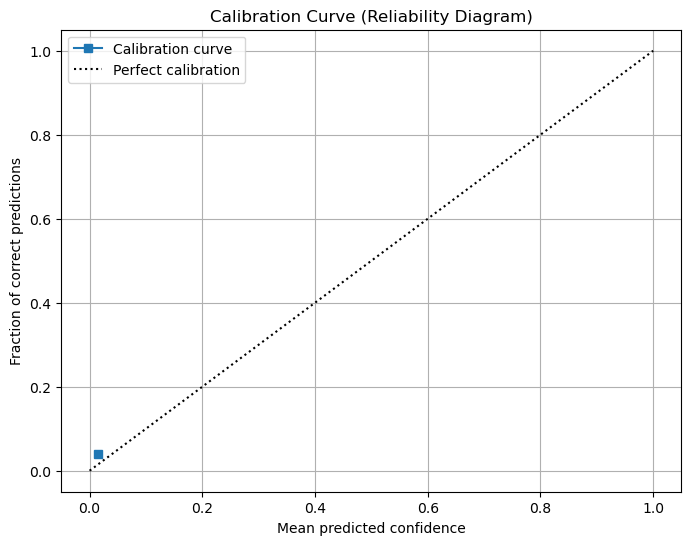

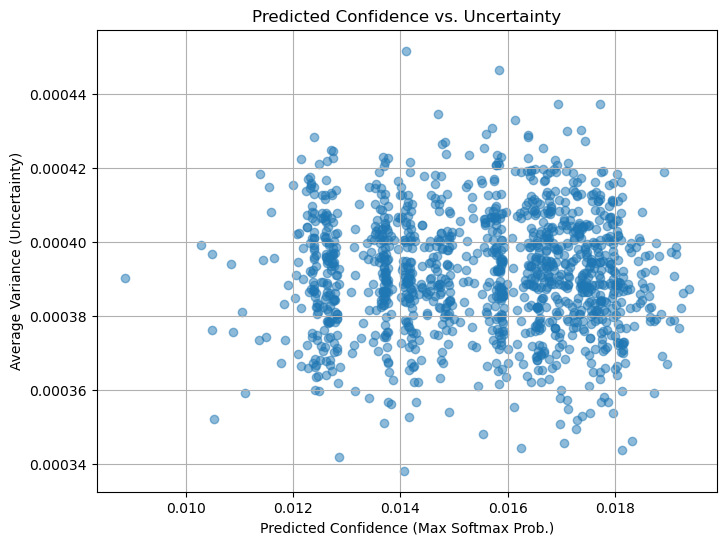

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Lists to store results for all test samples.
all_confidences = []  # Predicted maximum softmax probabilities
all_correct = []      # 1 if prediction is correct, 0 otherwise
all_variances = []    # A measure of uncertainty (here we compute the average variance from image and text MC dropout)

model.eval()
# Iterate over the test DataLoader.
for images, texts in dltest:
    # Convert images to device & proper dtype; texts remain integer tokens.
    images = images.to(device).to(model.dtype)
    texts = texts.to(device)
    
    # Run MC dropout inference (multiple forward passes) to get mean embeddings and variance.
    I_e_mean, I_e_var, T_e_mean, T_e_var = mc_dropout_forward(model, images, texts, num_samples=10)
    
    # Compute logits and softmax probabilities from the mean embeddings.
    scale = torch.exp(temp.to(device))
    logits = I_e_mean @ T_e_mean.T * scale
    probabilities = F.softmax(logits, dim=1)
    
    # Predicted confidence is the max softmax value; predicted class is the argmax.
    confidences, preds = torch.max(probabilities, dim=1)
    
    # Create a vector of ground truth labels for the batch (here assumed to be indices 0..B-1).
    labels = torch.arange(images.size(0), device=device)
    correct = preds.eq(labels).float()  # 1 if correct, 0 otherwise
    
    # Append to lists.
    all_confidences.extend(confidences.cpu().numpy())
    all_correct.extend(correct.cpu().numpy())
    
    # As a simple uncertainty measure, average the variance from image and text embeddings.
    # (You can also derive more sophisticated measures.)
    var_avg = (I_e_var.mean(dim=1) + T_e_var.mean(dim=1)) / 2.0  # Shape: [batch]
    all_variances.extend(var_avg.cpu().numpy())

# Compute calibration curve using scikit-learn.
fraction_of_positives, mean_predicted_value = calibration_curve(all_correct, all_confidences, n_bins=10)

# Plot the calibration (reliability) curve.
plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration curve")
plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
plt.xlabel("Mean predicted confidence")
plt.ylabel("Fraction of correct predictions")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(True)
plt.show()

# Additionally, plot a scatter plot of predicted confidence versus estimated uncertainty.
plt.figure(figsize=(8,6))
plt.scatter(all_confidences, all_variances, alpha=0.5)
plt.xlabel("Predicted Confidence (Max Softmax Prob.)")
plt.ylabel("Average Variance (Uncertainty)")
plt.title("Predicted Confidence vs. Uncertainty")
plt.grid(True)
plt.show()
